In [2]:
#import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import SimpleITK as sitk

import warnings
warnings.filterwarnings("ignore")

In [123]:
# File Directory for both the train and test
train_path = "./train"
valid_path = "./valid"
test_path = "D:/MINOR PROJECT/latst/LungcancerDataSet/Data/test"

In [ ]:
# Load CT image in DICOM format
ct_image = sitk.ReadImage('./train/adenocarcinoma/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib10.png')

# Normalize intensity values of the image
intensity_filter = sitk.RescaleIntensityImageFilter()
ct_image_normalized = intensity_filter.Execute(ct_image)

# Resize the image
resampler = sitk.ResampleImageFilter()
resampler.SetOutputSpacing([1, 1, 1])
resampler.SetSize([256, 256, 256])
ct_image_resized = resampler.Execute(ct_image_normalized)

# Apply a denoising filter
denoising_filter = sitk.CurvatureFlowImageFilter()
denoising_filter.SetNumberOfIterations(5)
ct_image_denoised = denoising_filter.Execute(ct_image_resized)

# Segment the lung region
segmentation_filter = sitk.ConnectedThresholdImageFilter()
segmentation_filter.SetLower(0)
segmentation_filter.SetUpper(300)
segmentation_filter.SetSeed([256, 256, 256])
ct_lung_segmented = segmentation_filter.Execute(ct_image_denoised)

# Extract features from the lung region
intensity_statistics = sitk.StatisticsImageFilter()
intensity_statistics.Execute(ct_lung_segmented)
lung_mean_intensity = intensity_statistics.GetMean()

# Save the preprocessed image and features
sitk.WriteImage(ct_lung_segmented, 'D:/Lung_Cancer/train/')

In [124]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        # Counting the Number of Files in the Folder
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;

train_set = GetDatasetSize(train_path)
valid_set = GetDatasetSize(valid_path)
test_set = GetDatasetSize(test_path)
print(train_set,"\n\n",valid_set,"\n\n",test_set)

{'adenocarcinoma': 780, 'Bengin cases': 320, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 460, 'Malignant cases': 1840, 'normal': 1820, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 620} 

 {'adenocarcinoma': 92, 'Bengin cases': 36, 'Large Cell Carcinoma': 84, 'Malignant cases': 147, 'normal': 212, 'Squamous Cell Carcimona': 60} 

 {'adenocarcinoma': 120, 'Bengin Case': 33, 'Large Cell Carcinoma': 102, 'Malignant Cases': 160, 'normal': 246, 'squamous.cell.carcinoma': 90}


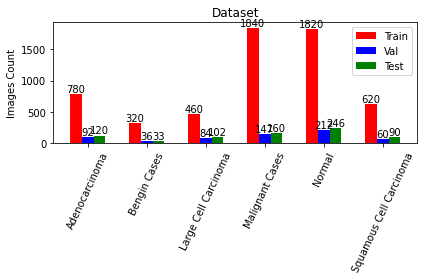

In [142]:
labels = ['Adenocarcinoma', 'Bengin Cases', 'Large Cell Carcinoma', 'Malignant Cases', 'Normal', 'Squamous Cell Carcinoma']
train_list = list(train_set.values())
val_list = list(valid_set.values())
test_list = list(test_set.values())

x = np.arange(len(labels))  # the label locations
width = 0.20  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_list, width, label='Train',color = 'red')
rects2 = ax.bar(x, val_list, width, label='Val', color = 'blue')
rects3 = ax.bar(x + width, test_list, width, label='Test', color = 'green')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Images Count')
ax.set_title('Dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(rotation=65)
ax.legend()

ax.bar_label(rects1)
ax.bar_label(rects2)
ax.bar_label(rects3)

fig.tight_layout()

plt.show()

In [126]:
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout

In [127]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0, horizontal_flip = True, fill_mode = 'nearest', zoom_range=0.2, shear_range = 0.2, 
                                   width_shift_range=0.2, height_shift_range=0.2, rotation_range=0.4)

train_data = train_datagen.flow_from_directory(train_path, batch_size = 5, target_size = (256,256), class_mode = 'categorical')

Found 5840 images belonging to 6 classes.


In [128]:
train_data.class_indices

{'Bengin cases': 0,
 'Malignant cases': 1,
 'adenocarcinoma': 2,
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 3,
 'normal': 4,
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 5}

In [129]:
val_datagen = ImageDataGenerator(rescale = 1.0/255.0)
val_data = val_datagen.flow_from_directory(valid_path, batch_size = 5, target_size = (256,256), class_mode = 'categorical')

Found 631 images belonging to 6 classes.


In [130]:
val_data.class_indices

{'Bengin cases': 0,
 'Large Cell Carcinoma': 1,
 'Malignant cases': 2,
 'Squamous Cell Carcimona': 3,
 'adenocarcinoma': 4,
 'normal': 5}

In [131]:
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_data = test_datagen.flow_from_directory(test_path, batch_size = 5, target_size = (256,256), class_mode = 'categorical')

Found 751 images belonging to 6 classes.


In [132]:
test_data.class_indices

{'Bengin Case': 0,
 'Large Cell Carcinoma': 1,
 'Malignant Cases': 2,
 'adenocarcinoma': 3,
 'normal': 4,
 'squamous.cell.carcinoma': 5}

Incep

In [38]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(input_shape = (256, 256, 3), 
                         include_top = False, 
                         weights = 'imagenet')


for layer in base_model.layers:
    layer.trainable = False


x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 4 node for classification output
x = layers.Dense(6, activation='sigmoid')(x)

model_incep = tf.keras.models.Model(base_model.input, x)

model_incep.compile(optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=0.0001), 
                    loss = 'categorical_crossentropy', 
                    metrics = ['accuracy'])

In [39]:
mc1 = ModelCheckpoint(
    filepath="./ct_incep_best_model.hdf5",
    monitor= 'val_accuracy', 
    verbose= 1,
    save_best_only= True, 
    mode = 'auto'
    );

call_back = [mc1];

In [40]:
# Fitting the Model
incep = model_incep.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 32, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back 
    )

Epoch 1/32
1168/1168 [==============================] - ETA: 0s - loss: 1.7600 - accuracy: 0.5899
Epoch 1: val_accuracy improved from -inf to 0.58571, saving model to .\ct_incep_best_model.hdf5
1168/1168 [==============================] - 1747s 1s/step - loss: 1.7600 - accuracy: 0.5899 - val_loss: 1.2272 - val_accuracy: 0.5857
Epoch 2/32
1168/1168 [==============================] - ETA: 0s - loss: 0.8542 - accuracy: 0.7009
Epoch 2: val_accuracy improved from 0.58571 to 0.68571, saving model to .\ct_incep_best_model.hdf5
1168/1168 [==============================] - 1728s 1s/step - loss: 0.8542 - accuracy: 0.7009 - val_loss: 0.7578 - val_accuracy: 0.6857
Epoch 3/32
1168/1168 [==============================] - ETA: 0s - loss: 0.7761 - accuracy: 0.7262
Epoch 3: val_accuracy improved from 0.68571 to 0.70714, saving model to .\ct_incep_best_model.hdf5
1168/1168 [==============================] - 1719s 1s/step - loss: 0.7761 - accuracy: 0.7262 - val_loss: 0.7976 - val_accuracy: 0.7071
Epoch 4

In [49]:
# Loading the Best Fit Model 
model_incep = load_model("./ct_incep_best_model.hdf5")

ResNet50

In [113]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(256, 256,3),
                      include_top=False, weights="imagenet", 
                      pooling='max')

In [114]:
for layer in base_model.layers:
    layer.trainable = False

In [115]:
model_resnet = Sequential()
model_resnet.add(base_model)
model_resnet.add(Dense(6, activation='sigmoid'))

In [116]:
model_resnet.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001), 
                     loss = 'categorical_crossentropy', 
                     metrics = ['accuracy'])

In [117]:
# Adding Model check point Callback

mc = ModelCheckpoint(
    filepath="./ct_resnet_best_model.hdf5",
    monitor= 'val_accuracy', 
    verbose= 1,
    save_best_only= True, 
    mode = 'auto'
    );

call_back = [mc];

In [119]:
# Fitting the Model
resnet = model_resnet.fit(
    train_data, 
    steps_per_epoch = train_data.samples//train_data.batch_size, 
    epochs = 15, 
    validation_data = val_data, 
    validation_steps = val_data.samples//val_data.batch_size,
    callbacks = call_back 
    ) 

Epoch 1/15
1168/1168 [==============================] - ETA: 0s - loss: 1.4082 - accuracy: 0.3767
Epoch 1: val_accuracy improved from -inf to 0.01026, saving model to .\ct_resnet_best_model.hdf5
1168/1168 [==============================] - 893s 764ms/step - loss: 1.4082 - accuracy: 0.3767 - val_loss: 2.8978 - val_accuracy: 0.0103
Epoch 2/15
1168/1168 [==============================] - ETA: 0s - loss: 1.2748 - accuracy: 0.4406
Epoch 2: val_accuracy improved from 0.01026 to 0.02051, saving model to .\ct_resnet_best_model.hdf5
1168/1168 [==============================] - 757s 648ms/step - loss: 1.2748 - accuracy: 0.4406 - val_loss: 3.5226 - val_accuracy: 0.0205
Epoch 3/15
1168/1168 [==============================] - ETA: 0s - loss: 1.2259 - accuracy: 0.4550
Epoch 3: val_accuracy did not improve from 0.02051
1168/1168 [==============================] - 910s 779ms/step - loss: 1.2259 - accuracy: 0.4550 - val_loss: 3.8228 - val_accuracy: 0.0137
Epoch 4/15
1168/1168 [=========================

In [133]:
# Loading the Best Fit Model 
model = load_model("./ct_resnet_best_model.hdf5")

In [136]:
test_score = model_incep.evaluate(test_data)
test_score_resnet = model.evaluate(test_data)

151/151 [==============================] - 96s 634ms/step - loss: 2.1079 - accuracy: 0.4061


In [ ]:
# Checking the Accuracy of the Model Resnet50
accuracy_resnet = model.evaluate_generator(generator= test_data)[1] 
print(f"The accuracy of the ResNet50 model is = {accuracy_resnet*100} %")
loss_resnet = test_score[0]
print(f"The loss of the ResNet50 model is = {loss_resnet} %")

The accuracy of the ResNet50 model is = 50.3157913684845 %
The loss of the ResNet50 model is = 1.5490968227386475 %


In [ ]:
# Checking the Accuracy of the Incep
accuracy_incep = model_incep.evaluate_generator(generator= test_data)[1] 
print(f"The accuracy of the Incep model is = {accuracy_incep*100} %")
loss_incep = test_score[0]
print(f"The loss of the Incep model is = {loss_incep} %")

The accuracy of the Incep model is = 73.68420958518982 %
The loss of the Incep model is = 1.5490968227386475 %


In [135]:
incep.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [137]:
resnet.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

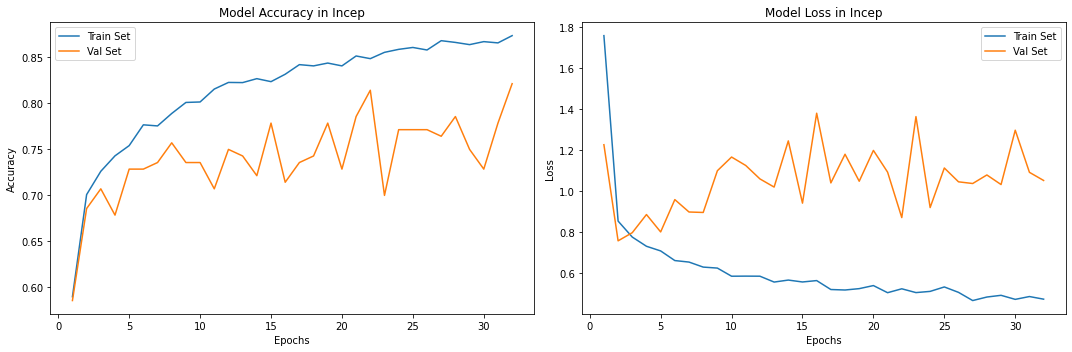

In [138]:
# Plot model performance
acc = incep.history['accuracy']
val_acc = incep.history['val_accuracy']
loss = incep.history['loss']
val_loss = incep.history['val_loss']
epochs_range = range(1, len(incep.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy in Incep')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss in Incep')

plt.tight_layout()
plt.show()

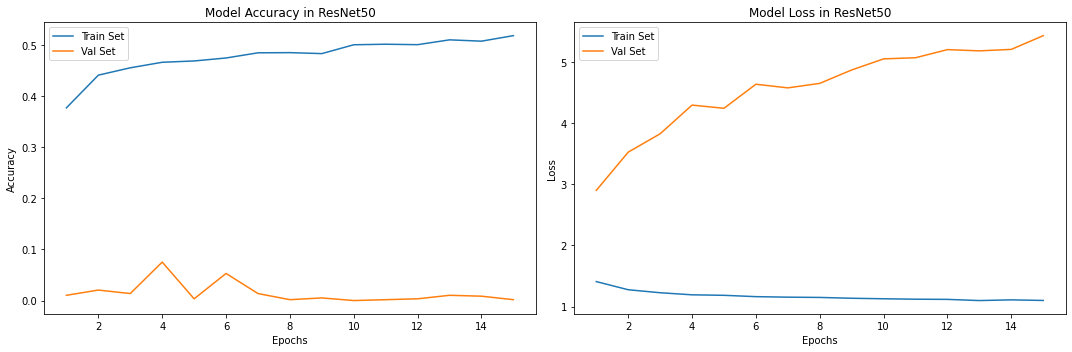

In [140]:
# Plot model performance
acc = resnet.history['accuracy']
val_acc = resnet.history['val_accuracy']
loss = resnet.history['loss']
val_loss = resnet.history['val_loss']
epochs_range = range(1, len(resnet.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy in ResNet50')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss in ResNet50')

plt.tight_layout()
plt.show()

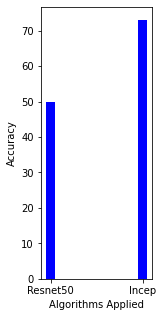

In [141]:
algos = ['Resnet50','Incep']
accuracy = [accuracy_resnet, accuracy_incep]
accuracy = np.floor([i * 100 for i in accuracy])
  
fig = plt.figure(figsize = (2, 5))
#fig.set_figwidth(4)
 
# creating the bar plot
plt.bar(algos, accuracy, color ='blue', width = 0.1)
 
plt.xlabel("Algorithms Applied")
plt.ylabel("Accuracy")
plt.show()

Confusion Matrix

Confusion Matrix
Normalized confusion matrix
Classification Report
                                                  precision    recall  f1-score   support

                                    Bengin cases       0.00      0.00      0.00        11
                                 Malignant cases       0.08      0.09      0.09        80
      adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib       0.24      0.38      0.30       120
   large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa       0.04      0.02      0.03        51
                                          normal       0.22      0.31      0.26       123
squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa       0.00      0.00      0.00        90

                                        accuracy                           0.19       475
                                       macro avg       0.10      0.13      0.11       475
                                    weighted avg       0.14      0.19      0.16       475



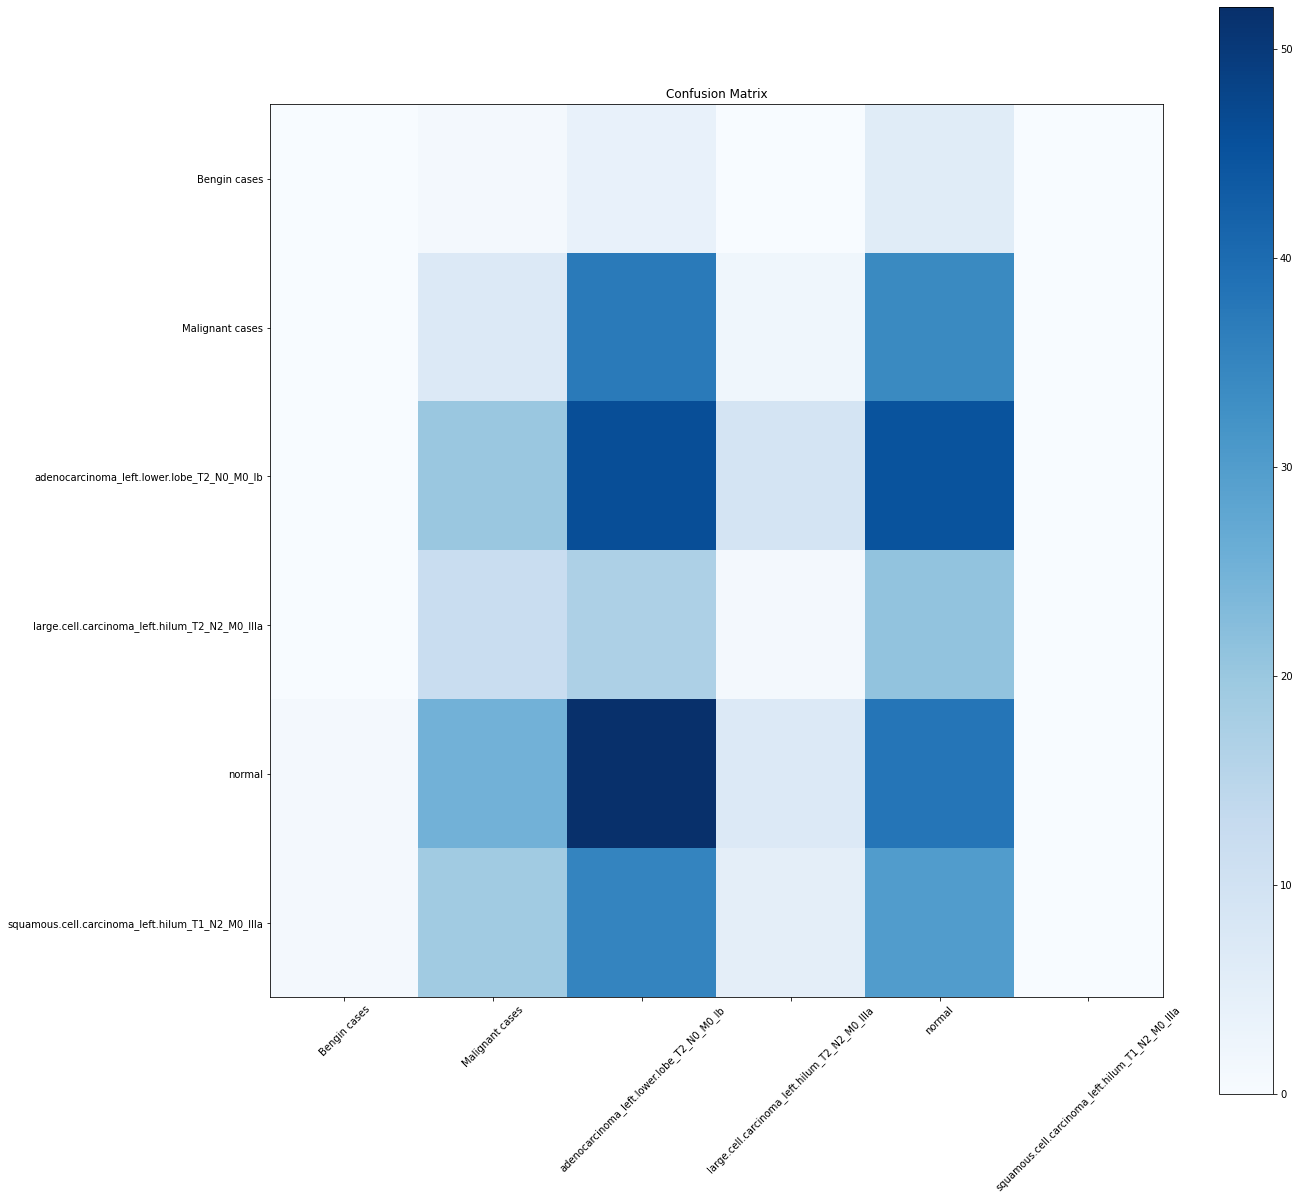

In [63]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
            plt.tight_layout()
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
#Print the Target names
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
#shuffle=False
target_names = []
for key in train_data.class_indices:
    target_names.append(key)
# print(target_names)
#Confution Matrix
Y_pred = model.predict_generator(test_data)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_data.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')
#Print Classification Report
print('Classification Report')
print(classification_report(test_data.classes, y_pred, target_names=target_names))

Prediction

In [66]:
def chestScanPrediction(path, _model):
    classes_dir = ["Adenocarcinoma","Bengin Cases","Large cell carcinoma","Malignant Cases","Normal","Squamous cell carcinoma"]
    # Loading Image
    img = image.load_img(path, target_size=(256,256))
    # Normalizing Image
    norm_img = image.img_to_array(img)/250
    # Converting Image to Numpy Array
    input_arr_img = np.array([norm_img])
    # Getting Predictions
    pred = np.argmax(_model.predict(input_arr_img))
    # Printing Model Prediction
    print(classes_dir[pred])

In [73]:
path = "./test/large.cell.carcinoma/BenginCases105.png"
chestScanPrediction(path,model_incep)

Large cell carcinoma
